In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import h5py
import src
import numpy as np
import k3d
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from ipywidgets import interact, widgets


Using TensorFlow backend.


In [7]:
cube = np.load('../data/raw/train_labels.npy')
cube = cube[15:cube.shape[0]-16, 15:cube.shape[1]-16, 15:cube.shape[2]-16]
cubek3d = cube + 1
plot = k3d.plot()
(w, h, d) = cubek3d.shape
obj = k3d.voxels(np.swapaxes(np.swapaxes(cubek3d, 0, 2), 0, 1), bounds=[0,w, 0,d,0,h], opacity=0.3, outlines=False)
plot += obj
plot.camera=[150, 230, -40, 60, 85, 80, 0.0, 0.0, -1.0]
plot.display()

71680755


Output()

In [ ]:
def pred_indexes(cube, sample_size):
    shape = cube.shape

    indexes = [
        (iline, xline, depth)
        for iline in range(shape[0] - sample_size + 1)
        for xline in range(shape[1] - sample_size + 1)
        for depth in range(shape[2] - sample_size + 1)
    ]

    return indexes

cube = np.arange(3*3*3).reshape(3,3,3)
indexes = pred_indexes(cube, 2)
print(len(indexes))

In [ ]:
from livelossplot.keras import PlotLossesCallback
from src.sequences import F3Sequence
from sklearn.utils.class_weight import compute_class_weight

def split_indexes(cube, sample_size):
    shape = cube.shape

    indexes = [
        (iline, xline, depth)
        for iline in range(shape[0] - sample_size)
        for xline in range(shape[1] - sample_size)
        for depth in range(shape[2] - sample_size)
    ]
    
    train_indexes, val_indexes = train_test_split(indexes, test_size=0.2, shuffle=True)
    return train_indexes, val_indexes

seismic_cube = np.load('../data/raw/train_seismic.npy')
facies_cube = np.load('../data/raw/train_labels.npy')

class_weights = compute_class_weight('balanced', np.unique(facies_cube), facies_cube.flatten())

batch_size = 500
sample_size = 32
input_shape = (sample_size, sample_size, 3)
n_classes = len(np.unique(facies_cube))

model = Sequential()

model.add(Conv2D(32, (7, 7), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(200))
model.add(Activation('relu'))

model.add(Dense(n_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

train_indexes, val_indexes = split_indexes(seismic_cube, sample_size)

training_sequence = F3Sequence(seismic_cube, facies_cube, train_indexes, batch_size, sample_size)
validation_sequence = F3Sequence(seismic_cube, facies_cube, val_indexes, batch_size, sample_size)

history = model.fit_generator(
    generator=training_sequence,
    validation_data=validation_sequence,
    use_multiprocessing=False,
    epochs=20,
    class_weight=class_weights,
    workers=4,
    verbose=1,
    callbacks=[PlotLossesCallback(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],    
)

In [ ]:
model.save('../models/trained_model_f3_32_full.h5')
print('Model saved!')

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Training examples: 1568
Example shape: (32, 32, 3)


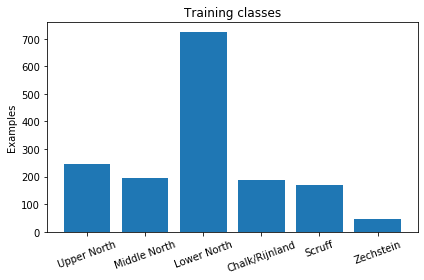

In [10]:
filename = '../data/interim/f3_32.h5'
with h5py.File(filename, 'r') as dataset:
    x_train_original = np.array(dataset['train/X'])
    y_train_original = np.array(dataset['train/Y'])
    
m = x_train_original.shape[0]

classnames = {
    0: 'Upper North',
    1: 'Middle North',
    2: 'Lower North',
    3: 'Chalk/Rijnland',
    4: 'Scruff',
    5: 'Zechstein',
}    

print(f'Training examples: {m}')
print(f'Example shape: {x_train_original[0].shape}')

train_freq = src.class_frequency(y_train_original, len(classnames))
src.plot_classes_freq(train_freq, classnames.values(), title='Training classes')

In [ ]:
nrows, ncols = 2, 5
idx = np.random.choice(m, nrows * ncols)

fig = plt.figure(figsize=(12, 5))
for i in range(1, nrows * ncols +1):
    fig.add_subplot(nrows, ncols, i)
    plt.imshow(x_train_original[idx[i-1]])
    plt.title(f'class: {classnames[y_train_original[idx[i-1]][0]]}')
    plt.xticks([])
    plt.yticks([]) 

In [ ]:
pred = np.load('../models/f3-train-pred.npy')  
predk3d = pred + 1
(w, h, d) = pred.shape
plot = k3d.plot()
obj = k3d.voxels(np.swapaxes(np.swapaxes(predk3d, 0, 2), 0, 1), bounds=[0,w, 0,d,0,h], opacity=0.5, outlines=False)
plot += obj
plot.camera=[150, 230, -40, 60, 85, 80, 0.0, 0.0, -1.0]
plot.display()

In [ ]:
def plot_section(z=0):
    fig, axes = plt.subplots(1, 2, dpi=250)
    axes[0].imshow(cube[:,:,z], vmin=0, vmax=5)
    axes[1].imshow(pred[:,:,z], vmin=0, vmax=5)

interact(plot_section, z=widgets.IntSlider(min=0,max=pred.shape[2] - 1,step=1,value=0))

In [ ]:
print('Evaluating model...\n')

y_true = cube.flatten()
y_pred = pred.flatten()

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

Test both
Evaluating model...

Mean-accuracy:    	0.884546689094611
Precision(macro): 	0.4418206545344765
Recall(macro):    	0.47078776302470055
F1-Score(macro):  	0.4503607885833098
FWIU:             	0.5203885052724063




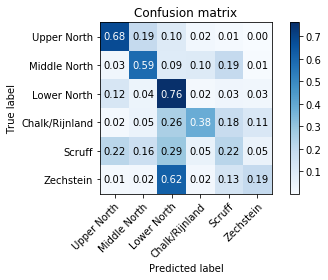

In [16]:
image_size = 32
true1_name = 'test1_labels.npy'
true2_name = 'test2_labels.npy'

cube_pred1_name = 'pred-f3_test1-32-wells.npy'
cube_pred2_name = 'pred-f3_test2-32-wells.npy'

cube_true1 = np.load(f'../data/raw/{true1_name}')
cube_true1 = src.remove_borders(cube_true1, image_size)
cube_true2 = np.load(f'../data/raw/{true2_name}')
cube_true2 = src.remove_borders(cube_true2, image_size)

cube_pred1 = np.load(f'../models/{cube_pred1_name}')
cube_pred2 = np.load(f'../models/{cube_pred2_name}')

y_true1 = cube_true1.flatten()
y_pred1 = cube_pred1.flatten()

y_true2 = cube_true2.flatten()
y_pred2 = cube_pred2.flatten()

# print('Test #1')
# results = evaluate(y_true1, y_pred1)
# show_results(results)
# print('\n')

# print('Test #2')
# results = evaluate(y_true2, y_pred2)
# show_results(results)
# print('\n')

print('Test both')
results = src.evaluate(np.concatenate((y_true1, y_true2)), np.concatenate((y_pred1, y_pred2)))
src.show_results(results, classnames)
print('\n')

In [ ]:
test1_true = np.load('../data/raw/test1_labels.npy')
test1_true = test1_true[15:test1_true.shape[0]-16, 15:test1_true.shape[1]-16, 15:test1_true.shape[2]-16]
test1_pred = np.load('../models/f3-test1-fullmodel-pred.npy')

def plot_section(z=0):
    fig, axes = plt.subplots(1, 2, dpi=250)
    axes[0].imshow(test1_true[z, :, :].T, vmin=0, vmax=5)
    axes[1].imshow(test1_pred[z, :, :].T, vmin=0, vmax=5)

interact(plot_section, z=widgets.IntSlider(min=0,max=test1_pred.shape[0] - 1,step=1,value=0))




In [ ]:
print('Evaluating model...\n')

y_true = test1_true.flatten()
y_pred = test1_pred.flatten()

accuracy = accuracy_score(y_true, y_pred, normalize=True)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: \t{accuracy}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

In [ ]:
test2_true = np.load('../data/raw/test2_labels.npy')
test2_true = test2_true[15:test2_true.shape[0]-16, 15:test2_true.shape[1]-16, 15:test2_true.shape[2]-16]
test2_pred = np.load('../models/f3-test2-fullmodel-pred.npy')

print(test2_true.shape)

def plot_section(z=0):
    fig, axes = plt.subplots(1, 2, dpi=250)
    axes[0].imshow(test2_true[z, :, :].T, vmin=0, vmax=5)
    axes[1].imshow(test2_pred[z, :, :].T, vmin=0, vmax=5)

interact(plot_section, z=widgets.IntSlider(min=0,max=test2_pred.shape[0] - 1,step=1,value=0))

In [ ]:
print('Evaluating model...\n')

y_true = test2_true.flatten()
y_pred = test2_pred.flatten()

accuracy = accuracy_score(y_true, y_pred, normalize=True)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: \t{accuracy}')
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

In [ ]:
a = np.array([1, 2, 3])

b = np.array([5, 5, 5])

def foo(a, b):
    return sum(a)/sum(b)